# Implementation of Navier-Stokes equation using fenicsx/dolfinx
## Steps to Navier-Stokes using Chorin's projection method
Momentum: $\rho \frac{D u}{Dt} = -\nabla p + \mu \nabla^2 u + \rho \mathbf{g}$

Continuity: $\nabla \cdot u = 0$
1. Taylor-Hood elements are used to avoid the saddle point problem. Pressure finite element space is one order lower than the velocity finite element space.

2. Solve the weak form of the momentum equation without the pressure gradient term. Convection is treated explicitly and diffusion is treated implictly. Tentative velocity step (solve without pressure gradient term).
$$0 = \frac{1}{\Delta t} \langle u^* - u, v \rangle +  \langle (\nabla u)u, v \rangle + \nu \langle \nabla u^*, \nabla v \rangle$$

3. Pressure Poisson solution to generate correct pressure
$$\langle \nabla p^*, \nabla q\rangle = -\frac{1}{\Delta t}\langle \nabla \cdot u^*,q \rangle$$

4. Final velocity update using the Chorin projection
$$ \langle u^{**},v \rangle  = \langle u^*, v \rangle - \frac{1}{\Delta t}\langle \nabla p^*, v \rangle$$


## Lid driven cavity
Lid driven cavity is a standard Drichilet problem solved on a square grid. The upper lid moves in the x direction with a fixed velocity and the generated solution has a swirling nature. The location of the center of the swirl is a function of the Reynolds number.

### Initial condition
Velocity components are zero everywhere. Homogeneous Dirichlet BC everywhere except the top. No applied volume forces.

### Glossary of variables
* $u$   (`u_prev`): Velocity field from previous iteration
* $u^*$  (`u_tent`): Velocity field after tentative momentum step
* $u^{**}$ (`u_next`): Velocity field corrected for incompressibility constraint
* $p^*$  (`p_next`): Pressure field at the next step
* $\Delta t$ (`dt`): Time step size
* v (`v`): Test function for u
* q (`q`): Test function for p

In [1]:
# Importing the standard libraries
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import dolfinx as fe
import ufl
import pyvista
import scipy as sci

In [2]:
N_POINTS_P_AXIS = 201
TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 1000
KINEMATIC_VISCOSITY = 0.0025 # -> Re = 400

In [3]:
mesh = fe.mesh.create_unit_square(MPI.COMM_WORLD,N_POINTS_P_AXIS, N_POINTS_P_AXIS)

# Taylor-Hood Elements. The order of the function space for the pressure has
# to be one order lower than for the velocity. Elements are defined 
velocity_element = ufl.VectorElement('CG',mesh.ufl_cell(), 2) # CG stands for Continuous-Galerkin
pressure_element = ufl.FiniteElement('CG',mesh.ufl_cell(), 1)

velocity_function_space = fe.fem.FunctionSpace(mesh, velocity_element)
pressure_function_space = fe.fem.FunctionSpace(mesh, pressure_element)

u_trial = ufl.TrialFunction(velocity_function_space)
p_trial = ufl.TrialFunction(pressure_function_space)
v_test = ufl.TestFunction(velocity_function_space)
q_test = ufl.TestFunction(pressure_function_space)

In [4]:
# Define the Boundary Condition
def stationary_walls(x):
    return np.logical_or(np.isclose(x[0],0), np.isclose(x[0],1),np.isclose(x[1],0))

stationary_walls_dofs = fe.fem.locate_dofs_geometrical(
    velocity_function_space, 
    stationary_walls)

u_noslip = np.array(
    (0.0,0.0,),
    dtype=PETSc.ScalarType)


stationary_wall_boundary_condition = fe.fem.dirichletbc(
    u_noslip,
    stationary_walls_dofs,
    velocity_function_space)

def moving_wall(x):
    return np.isclose(x[1],1.0)

moving_walls_dofs = fe.fem.locate_dofs_geometrical(
    velocity_function_space, 
    moving_wall)

u_moving = np.array(
    (1.0,0.0),
    dtype=PETSc.ScalarType)

moving_wall_boundary_condition = fe.fem.dirichletbc(
    u_moving,
    moving_walls_dofs,
    velocity_function_space)

# Vector containing the defined BCs
velocity_boundary_conditions = [stationary_wall_boundary_condition, moving_wall_boundary_condition]

In [5]:
# Define the solution fields involved
u_tent = fe.fem.Function(velocity_function_space)
u_next = fe.fem.Function(velocity_function_space)
p_next = fe.fem.Function(pressure_function_space)

In [6]:
# Weak form of the momentum equation
momentum_weak_form_residuum = (
    1.0 / TIME_STEP_LENGTH * ufl.inner(u_trial - u_next, v_test) * ufl.dx
    +
    ufl.inner(ufl.nabla_grad(u_next) * u_next, v_test) * ufl.dx
    +
    KINEMATIC_VISCOSITY * ufl.inner(ufl.nabla_grad(u_trial), ufl.nabla_grad(v_test)) * ufl.dx
)
momentum_weak_form_lhs = fe.fem.form(ufl.lhs(momentum_weak_form_residuum))
momentum_weak_form_rhs = fe.fem.form(ufl.rhs(momentum_weak_form_residuum))

In [7]:
# Weak form of the pressure poisson problem
pressure_poisson_weak_form_lhs = fe.fem.form(ufl.inner(ufl.nabla_grad(p_trial), ufl.nabla_grad(q_test)) * ufl.dx)
pressure_poisson_weak_form_rhs = fe.fem.form(- 1.0 / TIME_STEP_LENGTH * ufl.nabla_div(u_tent) * q_test * ufl.dx)

In [8]:
# Weak form of the velocity update equation
velocity_update_weak_form_lhs = fe.fem.form(ufl.inner(u_trial, v_test) * ufl.dx)
velocity_update_weak_form_rhs = fe.fem.form(
    ufl.inner(u_tent, v_test) * ufl.dx
    -
    TIME_STEP_LENGTH * ufl.inner(ufl.nabla_grad(p_next), v_test) * ufl.dx
)

In [9]:
# Pre-Compute the system matrices (because they do not greatly change)
momentum_assembled_system_matrix = fe.fem.petsc.assemble_matrix(momentum_weak_form_lhs, bcs=velocity_boundary_conditions)
momentum_assembled_system_matrix.assemble()
pressure_poisson_assembled_system_matrix = fe.fem.petsc.assemble_matrix(pressure_poisson_weak_form_lhs)
pressure_poisson_assembled_system_matrix.assemble()
velocity_update_assembled_system_matrix = fe.fem.petsc.assemble_matrix(velocity_update_weak_form_lhs)
velocity_update_assembled_system_matrix.assemble()

In [10]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(momentum_assembled_system_matrix)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(pressure_poisson_assembled_system_matrix)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(velocity_update_assembled_system_matrix)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [11]:
for t in tqdm.tqdm(range(N_TIME_STEPS)):
    # (1) Solve for tentative velocity
    momentum_assembled_rhs = fe.fem.petsc.assemble_vector(momentum_weak_form_rhs)
    # This statement is needed to update the RHS with new solution variable and apply BCs after each time step
    fe.fem.apply_lifting(momentum_assembled_rhs, [momentum_weak_form_lhs],[velocity_boundary_conditions])
    momentum_assembled_rhs.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fe.fem.petsc.set_bc(momentum_assembled_rhs, velocity_boundary_conditions)
    solver1.solve(momentum_assembled_rhs, u_tent.vector)
    u_tent.x.scatter_forward()
        
    # (2) Solve for the pressure
    pressure_poisson_assembled_rhs = fe.fem.petsc.assemble_vector(pressure_poisson_weak_form_rhs)
    pressure_poisson_assembled_rhs.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver2.solve(pressure_poisson_assembled_rhs, p_next.vector)
    p_next.x.scatter_forward()
    
    # (3) Correct the velocities to be incompressible
    velocity_update_assembled_rhs = fe.fem.petsc.assemble_vector(velocity_update_weak_form_rhs)
    fe.fem.petsc.set_bc(momentum_assembled_rhs, velocity_boundary_conditions)
    velocity_update_assembled_rhs.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(velocity_update_assembled_rhs, u_next.vector)
    u_next.x.scatter_forward()

100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s] 


In [12]:
u_next.vector.array.mean()

0.0045938878509272875

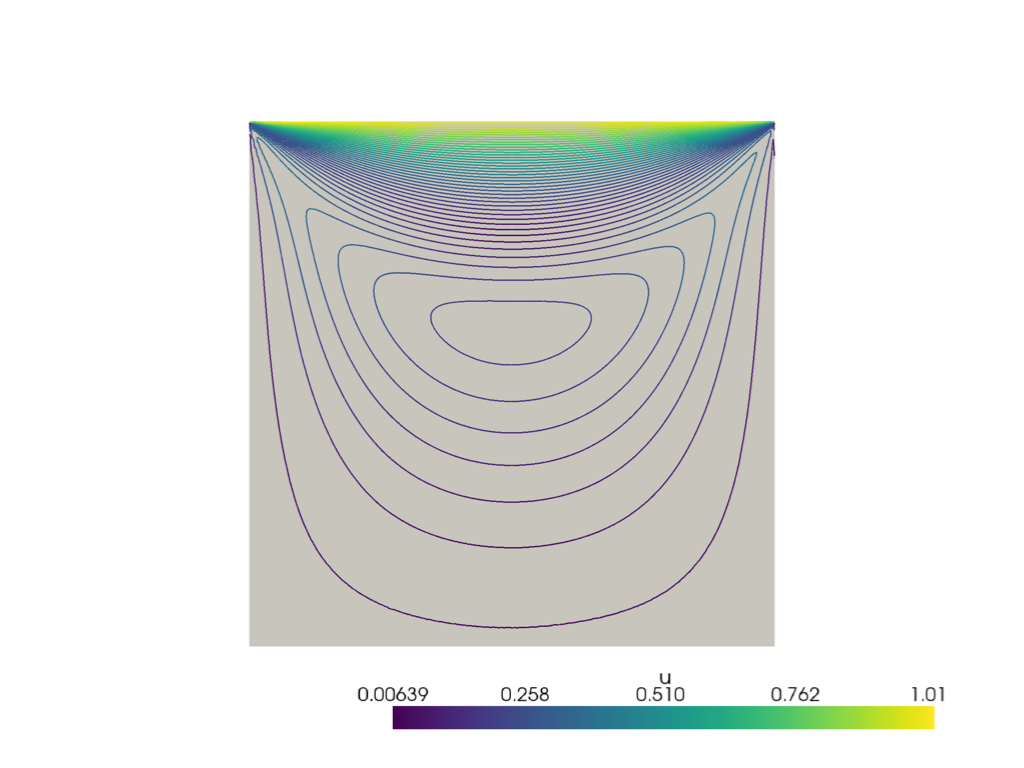

In [13]:
pyvista.set_jupyter_backend("static")
pyvista.global_theme.anti_aliasing = 'ssaa'
pyvista.global_theme.background = 'white'
pyvista.global_theme.font.color = 'black'

topology, cell_types, geometry = fe.plot.create_vtk_mesh(velocity_function_space)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_next)] = u_next.x.array.real.reshape((geometry.shape[0], len(u_next)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u",scale=False,factor=0.02,)
contour = function_grid.contour(isosurfaces=50)

# Create a pyvista-grid for the mesh
grid = pyvista.UnstructuredGrid(*fe.plot.create_vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()

plotter.add_mesh(function_grid, style="surface", color="white",show_edges=False)
#plotter.add_mesh(glyphs)
plotter.add_mesh(contour,line_width=3)
plotter.view_xy()

if pyvista.OFF_SCREEN:
    pyvista.start_xvfb()
    fig_as_array = plotter.screenshot("glyphs.png")
else:
    plotter.show()